# DNA
- Prepare DNA that is infinitely long.  
    - Use our web server: https://yoo.skku.edu/apps/application/dna  
        - If you want to simulate a DNA of finite lengths, you can prepare the moleculetype by using `gmx pdb2gmx`.  
        - We made the web server because no MD package can generate DNA effectively infinite under PBC.  
    - The web server generates dsDNA of any sequence.  
    - The length of DNA should be close to a multiple of 10.5, which is the periodicity of dsDNA.  
        - 10, 11, 21 bp, 32 bp, 42 bp etc.  
        - For example, try "atagcatcatatatataaaag"  
- AMBER force field has two major models for DNA  
    - BSC0  
    - BSC1  
    - BSC1 is newer than BSC0. But, both are still actively used.  

<img src="../img/inf_dna.png" width=200 />

#### **Outputs from web server**
- `amber*.ff`: force fields in Gromacs format.  
- `conf.pdb`: Structure file of dsDNA.  
    - Confirm the periodicity by drawing periodic images.  
- `topol.top`: topology file ready to use.  
- `*.mdp`: MDP files for Gromacs.  
- Moleculetype definitions:  
    - `dna.itp`: the essential moleculetype definition for you dsDNA.  
    - `dna.pbc.itp`: contains the connectivity between two ends of strands.  
    - `dna.hbonds.itp`: contains constraints between complementary pairs. Optional.  
    - `dna.enm.itp`: contains ENM-like constraints. It can be useful during equilibration. Optional.  

<img src="../img/server.png" width=300 />

### **Perform MD of dsDNA in solution**
- The package is ready to run MD.  
- See `dna.pdb` file. The CRYST definition will look like this:  
    - `CRYST1   60.000   60.000   70.980  90.00  90.00  60.00 P 1           1`
        - This indicates that you have a hexagonal simulation box: numbers indicates x, y, z, alpha, beta, gamma in   the crystallographer's convention.
        - You can adjust the box size in x and y directions. But the z-dimension cannot be changed because it matches   the periodicity of dsDNA.
- Add water molecules by using gmx solvate.  
    - `gmx solvate -cp dna.pdb -o conf.pdb -p topol.top`
- Then, `topol.top` file will look like this:  
    ```bash
    ; Include forcefield parameters
    #include "amber99bsc0.ff/forcefield.itp"

    ;#define POSRES
    #include "dna.itp"
    #include "dna.pbc.itp"
    #include "dna.hbonds.itp"
    ;#include "posre.itp"
    ;#include "dna.enm.itp"

    ; Include water topology
    #include "amber99bsc0.ff/tip3p.itp"

    ; Include topology for ions
    #include "amber99bsc0.ff/ions.itp"

    [ system ]
    ; Name
    loop in water

    [ molecules ]
    ; Compound        #mols
    DNA_chain_A         1
    SOL              7618
    ```

### **Add ions & minimize**
- `gmx grompp`  
    - `gmx grompp -f mini.mdp -c conf.pdb -maxwarn 40`  
    - `gmx genion` take TPR file as an input.   
- Add ions using gmx genion  
    - `gmx genion -neutral -conc 0.15 -o conf.pdb -p topol.top`  
        - `-neutral`: add ions such that the system becomes neutral.  
        - `-conc`: add more ions to get 0.15 M.  
        - See `topol.top` to confirm the changes.  
- Minimization  
    - `gmx grompp -f mini.mdp -c conf.pdb -maxwarn 40`  
    - `gmx mdrun -c conf.pdb`  
    - the minimized structure will be written to `conf.pdb`  
- Gromacs mdrun put molecules in a rectangular box by default. If you want to see the hexagonal box, try this:  
    - `gmx trjconv -f conf.pdb -o conf.pdb -pbc mol -ur compact`  
- Confirm the minimized system in VMD or pymol.  

<img src="../img/ion.png" width=400 />

### **MDRUN**
- Copy `mini.mdp` to `grompp.mdp`
- Modify `grompp.mdp` like this:
    ```bash
    ; RUN CONTROL PARAMETERS
    integrator               = md
    ; Start time and timestep in ps
    tinit                    = 0
    dt                       = 0.002
    nsteps                   = 500000000

    ; Temperature coupling  
    tcoupl                   = v-rescale
    print-nose-hoover-chain-variables = no
    ; Groups to couple separately
    tc_grps                  = system
    ; Time constant (ps) and reference temperature (K)
    tau_t                    = 0.5
    ref_t                    = 300
    ```
    - Because we have a dsDNA along the z axis, the box size in z must be decoupled from x and y sizes. Similar to the lipid bilayer systems, this DNA system fits best with semi-isotropic box.  
    ```bash
    ; pressure coupling     
    Pcoupl                   = c-rescale
    Pcoupltype               = semi-isotropic
    ; Time constant (ps), compressibility (1/bar) and reference P (bar)
    tau-p                    = 1.0
    compressibility          = 4.5e-5 4.5e-5 
    ref-p                    = 1      1
    ```

- `gmx mdrun`  
    - `gmx grompp -f grompp.mdp -c conf.pdb -maxwarn 40`
    - `gmx mdrun`  

### **Analysis**
- Visual inspection using VMD or pymol.  
    - Try to visualize the 3D distribution of ions using volmap in VMD.  
- Plot the radial distribution function of NA with respect to P atoms.  
    - In VMD  
        - Extensions => Analysis => Radial Pair Distribution Function  
        - Select "name P" and "name NA"  
    - In Gromacs  
        - `gmx rdf -f XTC_FILE`  
- Draw the concentrations of Na and Cl ions as a function of distance from DNA.  
    - This is called the "counterion condensation" around DNA.  
    - For analysis you need to coordinates of center of mass of dsDNA and coordinates of individual ions.  
    - `gmx traj` is a Gromacs tool that print out text format coordinates from XTC files.  
    - Center DNA in your simulation box.  
        - In the output XTC file from MDRUN, DNA molecules move freely. For the analysis, having dsDNA at the center of hexagonal box is convenient.  
        - `gmx trjconv` can do it:  
            - `gmx trjconv -f traj_comp.xtc -o center.xtc -pbc mol -ur compact -center`  
                - Select group for centering: DNA  
                - Select group for output: 0  
                - `-f`: input XTC  
                - `-o`: output XTC.  
                - `-pbc mol -ur compact`: put water and ions in hexagonal box.  
                - `-center`:  chosen molecules will be put at the center of box. By doing this, your trajectory will be DNA-centric.  
            - Confirm `center.xtc` using VMD or pymol.  
    - To print CM of dsDNA  
        -` gmx traj -s topol.tpr -f center.xtc -ox coord_dna.xvg -com`  
            - Choose DNA  
            - `-ox`: Coordinates will be written to `coord_dna.xvg` file.  
            - `-com`: With this option, center of mass coordinate will be written. Otherwise, coordinates of ALL atoms of DNA will be written.  
    - To print coorinates of ions  
        - `gmx traj -s topol.tpr -f center.xtc -ox coord_na.xvg`  
            - Choose Na  
            - Because we didn't specify -com option, coord_na.xvg will contain coordinates of all Na ions.  
            ```bash
                0      {x, y, z of ion 1}  {x, y, z of ion 2} ...
                20     {x, y, z of ion 1}  {x, y, z of ion 2} ...
                40     {x, y, z of ion 1}  {x, y, z of ion 2} ...
                60     {x, y, z of ion 1}  {x, y, z of ion 2} ...
                ...
                ```

    - By using `coord_dna.xvg` and `coord_na.xvg`, calculate the distance between DNA and each Na ion, using your favorite tools such as numpy, Excel, etc.  
    - Bin the distance to draw a histogram as a function of r.  
        - Average over entire simulation time.  
    - Then, you will see the ion density profile similar to the theory of counterion condensation.  

In [6]:
# Import modules
import numpy as np
import mdtraj as md
import matplotlib.patches as patches

### Loading trajectory

In [2]:
dir_path = "/home/wowjason/work/projects/md_lect/dna_under_pbc"
traj_path = f"{dir_path}/center.xtc"
topology_path = f"{dir_path}/conf.pdb"

traj_filename = traj_path.split("/")[-1]
topology_filename = topology_path.split("/")[-1]
traj = md.load(traj_path, top=topology_path)
print(f"Trajectory file : {traj_filename}\nTopology file : {topology_filename}")
print(f"Number of frames : {traj.n_frames}\nNumber of atoms : {traj.n_atoms}\nNumber of residues : {traj.n_residues}")

Trajectory file : center.xtc
Topology file : conf.pdb
Number of frames : 1001
Number of atoms : 24030
Number of residues : 7660


### Extract coordinates of targets
- Center of mass(COM) of DNA
- Coordinates of Na ions

In [3]:
com_dna = md.compute_center_of_mass(traj, select="chainid 0")
print(com_dna)

na_selection = traj.topology.select("resname NA")
traj_na = traj.atom_slice(na_selection)
coord_na = traj_na.xyz
number_of_na = coord_na.shape[1]

print(f"Center of mass(COM) of DNA loaded\nShape of com_dna : {com_dna.shape}")
print(f"Coordinates of Na ions\nNumber of Na ions : {number_of_na}")

[[4.52320875 2.58985137 3.54335242]
 [4.65969776 2.69163698 3.53581051]
 [4.67785949 2.71060081 3.55451222]
 ...
 [4.70989777 2.7153088  3.52512296]
 [4.69886721 2.72600316 3.54419535]
 [4.70215877 2.71861433 3.5318446 ]]
Center of mass(COM) of DNA loaded
Shape of com_dna : (1001, 3)
Coordinates of Na ions
Number of Na ions : 62


### Counterion condensation

(1001, 62)


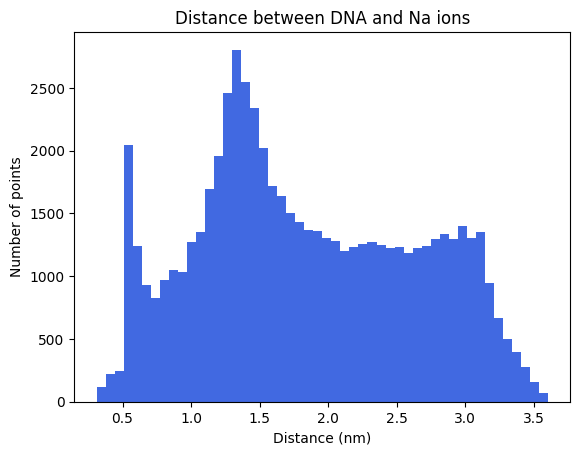

In [4]:
import matplotlib.pyplot as plt

com_dna_xy = com_dna[:, :2]
na_coord_xy = coord_na[:, :, :2]

distance_xy = np.linalg.norm(com_dna_xy[:, None, :] - na_coord_xy, axis=2)
print(distance_xy.shape)

plt.figure()
plt.hist(distance_xy.flatten(), bins=50, density=False, color="royalblue")
plt.title("Distance between DNA and Na ions")
plt.xlabel("Distance (nm)")
plt.ylabel("Number of points")

plt.show()

# avg_distance_xy = np.mean(distance_xy, axis=0)

# plt.figure()
# plt.hist(avg_distance_xy, bins=20, density=False, color="mediumspringgreen")
# plt.title("Average distance between DNA and Na ions")
# plt.xlabel("Distance (nm)")
# plt.ylabel("Number of points")

# plt.show()

### Visualize counterion condensation with 2D histogram

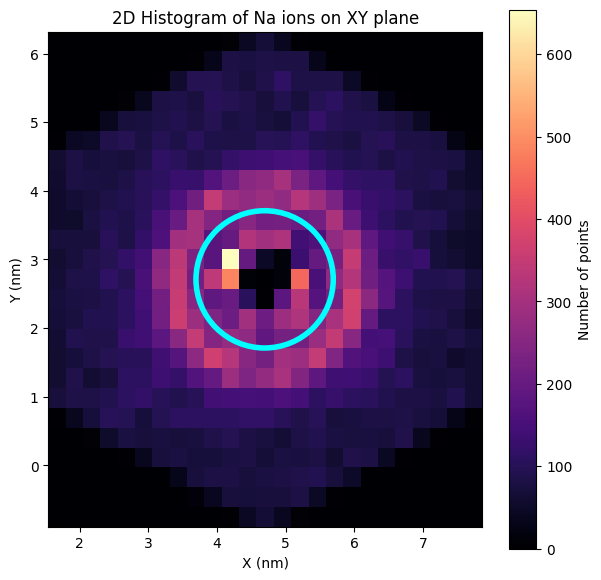

In [7]:
avg_com_dna = np.mean(com_dna_xy, axis=0)

plt.figure(figsize=(7, 7))
plt.hist2d(coord_na[:, :, 0].flatten(), coord_na[:, :, 1].flatten(), bins=25, cmap='magma')

circle = patches.Circle(avg_com_dna, 1, color='cyan', fill=False, linewidth=4)
plt.gca().add_patch(circle)
cbar = plt.colorbar()

plt.title("2D Histogram of Na ions on XY plane")
plt.xlabel("X (nm)")
plt.ylabel("Y (nm)")
cbar.set_label('Number of points')
plt.axis("scaled")

plt.show()